<a href="https://colab.research.google.com/github/kumarmanishjha/pgm-prjoject_A18/blob/master/modified_CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf

from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda, Concatenate
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.utils import to_categorical
from keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, Reshape, AveragePooling2D, UpSampling2D

#MNIST
num_classes = 10
(x_train, y_train_), (x_test, y_test_) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(*x_train.shape, 1)
x_test = x_test.reshape(*x_test.shape, 1)
y_train = to_categorical(y_train_, num_classes)
y_test = to_categorical(y_test_, num_classes)

m = 10
n_epoch = 20

latent_dim= 2

#Use image and label as input together

# Q(z|X,y) -- encoder

pic_size = 28
channel = 1

inputs = Input(shape=(pic_size,pic_size,channel))

print(inputs.shape)


y = Input(shape=(num_classes,))
print(y.shape)

yh = Dense(latent_dim)(y)
print(yh.shape)


Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
(?, 28, 28, 1)
(?, 10)
(?, 2)


In [2]:
print(inputs.shape)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
print(x.shape)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = AveragePooling2D(pool_size=(2, 2))(x)
print(x.shape)
x = Dropout(0.2)(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = AveragePooling2D(pool_size=(2, 2))(x)
print(x.shape)
x = Dropout(0.2)(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = AveragePooling2D(pool_size=(2, 2))(x)
print(x.shape)
x = Dropout(0.2)(x)


x = Flatten()(x)
print(x.shape)

h = Dense(pic_size, activation='relu')(x)
print(h.shape)



(?, 28, 28, 1)
(?, 28, 28, 32)
(?, 28, 28, 32)
(?, 14, 14, 32)
(?, 14, 14, 64)
(?, 14, 14, 64)
(?, 7, 7, 64)
(?, 7, 7, 128)
(?, 7, 7, 128)
(?, 3, 3, 128)
(?, ?)
(?, 28)


In [3]:
# calculate the mu and sigmas 
mu = Dense(latent_dim)(h)
print(mu.shape)
log_sigma = Dense(latent_dim)(h)
print(log_sigma.shape)


(?, 2)
(?, 2)


In [4]:
def sample_z(args):
    mu, log_sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return mu + K.exp(0.5 * log_sigma) * epsilon
  
z = Lambda(sample_z)([mu, log_sigma])
print(z.shape)

(?, 2)


In [5]:
#Encoder Model
encoder = Model(inputs, [mu, log_sigma, z])
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 14, 14, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dropout_1 

In [6]:
#decoder

latent_inputs = Input(shape=(latent_dim,))
print(latent_inputs.shape)

x = Dense(7*7*pic_size, activation='relu')(latent_inputs)
print(x.shape)
x = Reshape((7,7,pic_size))(x)
print(x.shape)


x = UpSampling2D((2, 2))(x)
print(x.shape)
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
print(x.shape)

x = UpSampling2D((2, 2))(x)
print(x.shape)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
print(x.shape)

x = UpSampling2D((1, 1))(x)
print(x.shape)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
print(x.shape)

h_decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
print(h_decoded.shape)

decoder = Model(latent_inputs, h_decoded)
decoder.summary()

(?, 2)
(?, 1372)
(?, 7, 7, 28)
(?, 14, 14, 28)
(?, 14, 14, 256)
(?, 14, 14, 256)
(?, 28, 28, 256)
(?, 28, 28, 128)
(?, 28, 28, 128)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 64)
(?, 28, 28, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1372)              4116      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 28)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 28)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 256)       64768     
_________________________________________________________________
conv2d_8 (Co

In [0]:
outputs = decoder(encoder(inputs)[2])


vae = Model([inputs, y], [outputs, yh])

In [8]:
#define loss
reconstruction_loss = binary_crossentropy(inputs, outputs) *pic_size*pic_size
reconstruction_loss = K.mean(reconstruction_loss)
print(reconstruction_loss)

kl_loss = 1 + log_sigma - K.square(mu - yh) - K.exp(log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
print(kl_loss)

vae_loss = K.mean(reconstruction_loss + kl_loss)
print(vae_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer = 'adam')
vae.summary()



Tensor("Mean_1:0", shape=(), dtype=float32)
Tensor("mul_2:0", shape=(?,), dtype=float32)
Tensor("Mean_2:0", shape=(), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 2), (None, 2 318832      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 28, 28, 1)    1212885     model_1[1]

In [10]:
vae.fit([x_train, y_train], batch_size = m, epochs = 2)

Epoch 1/2
60000/60000 [==============================] - 252s 4ms/step - loss: 149.4764
Epoch 2/2
60000/60000 [==============================] - 251s 4ms/step - loss: 147.1005


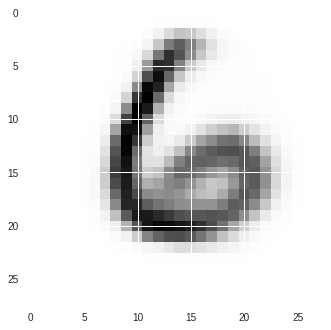

In [11]:
#randomly sample one sample from N(0, I)
mean = np.zeros((latent_dim))
cov = np.identity(latent_dim)

sample = np.random.multivariate_normal(mean, cov, 1000)

pred = decoder.predict(sample, batch_size = m)

#%%

plt.imshow((pred[500,:]*255).reshape(28, 28))
